In [1]:
import os, sys
from tqdm import trange, tqdm

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import gradio as gr
from PIL import Image

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from preprocessing import Direct
from activations import get_activations
from data_analysis.visualization.publication import pub_show

In [2]:
# https://kushaj.medium.com/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

In [3]:
train_dir = "/home/loek/projects/rnn/DNN/data/ImageNet/tiny-imagenet-two_classes/train"

size = 224
# size = 64
batch_size = 32
num_workers = 8
num_classes = 1000

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.CenterCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

image_datasets = {
    "train": ImageFolder(train_dir, transform=data_transforms["train"]),
    # "val": ImageFolder(val_dir, transform=data_transforms["val"]),
}

data_loader = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    for x in ["train"]
}

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2, bias=False),
            # nn.Linear()
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv_4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv_5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.fc_base = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_5(self.conv_4(self.conv_3(self.conv_2(self.conv_1(x)))))
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.fc_base(x)
        return x

    def get_representations(self, x):
        conv_layers = [
            self.conv_1,
            self.conv_2,
            self.conv_3,
            self.conv_4,
            self.conv_5,
        ]
        activations = []
        for layer in conv_layers:
            x = layer(x)
            activations.append(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.fc_base(x)
        activations.append(x)

        return activations

In [5]:
model = AlexNet()
gain = 1.5

# conv_list = [0, 4, 8, 10, 12]
fc_list = [1, 4, 6]
conv_list = [model.conv_1, model.conv_2, model.conv_3, model.conv_4, model.conv_5]
for layer in conv_list:
    torch.nn.init.kaiming_normal_(layer[0].weight)
    # torch.nn.init.xavier_normal_(layer[0].weight, gain=0.01)
for i in fc_list:
    torch.nn.init.kaiming_normal_(model.fc_base[i].weight)
    # torch.nn.init.xavier_normal(model.fc_base[i].weight, gain=gain)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(
    device
)  # Cross entropy loss takes the logits directly, so we don't need to apply softmax in our CNN
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", verbose=True)

cpu


In [7]:
# Get test data
model.eval()
for batch in torch.utils.data.DataLoader(
    image_datasets["train"], batch_size=64, shuffle=True
):
    test_inputs, test_outputs = batch
    break

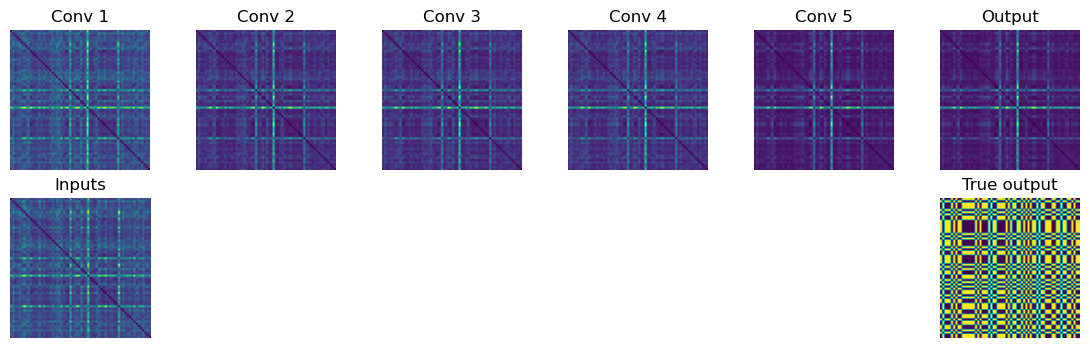

In [8]:
model.eval()
hs_0 = model.get_representations(test_inputs)


def kernel(h):
    model.eval()
    h = h.detach()
    kernel = np.array([[torch.sum((h_1 - h_2) ** 2) for h_1 in h] for h_2 in h])
    return kernel


true_outputs = nn.functional.one_hot(test_outputs, num_classes=num_classes)


fig = plt.figure(figsize=(14, 4))


for i in range(5):
    plt.subplot(2, 6, i + 1)
    plt.imshow(kernel(hs_0[i]))
    plt.axis("off")
    plt.title(f"Conv {i+1}")


plt.subplot(2, 6, 6)
plt.imshow(kernel(hs_0[5]))
plt.axis("off")
plt.title("Output")

plt.subplot(2, 6, 7)
plt.imshow(kernel(test_inputs))
plt.axis("off")
plt.title("Inputs")

plt.subplot(2, 6, 12)
plt.imshow(kernel(true_outputs))
plt.axis("off")
plt.title("True output")


plt.show()

In [9]:
# # Train

model.train()
iterator = trange(10)
for epoch in iterator:
    for batch in data_loader["train"]:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iterator.set_description(f"Training... (loss: {loss.detach():.4f})")

Training... (loss: 0.2016): 100%|██████████| 10/10 [08:33<00:00, 51.36s/it]


In [10]:
# Train

# model.train()
# try:
#     data_it = tqdm(data_loader["train"])
#     for n, batch in enumerate(data_it):
#         inputs, labels = batch
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         data_it.set_description(f"Training... (loss: {loss.detach():.4f})")
#         if n > 100:
#             break
# except Exception as e:
#     traceback.print_exc()
#     raise e
# finally:
#     pass

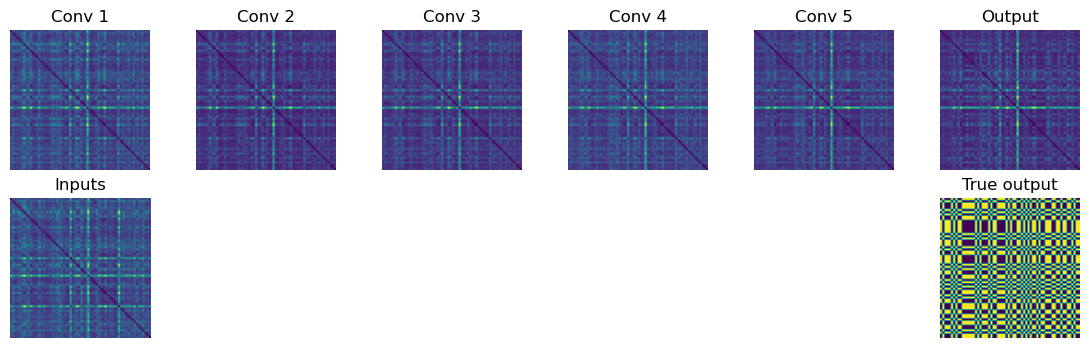

In [11]:
model.eval()
hs = model.get_representations(test_inputs)


true_outputs = nn.functional.one_hot(test_outputs, num_classes=num_classes)


fig = plt.figure(figsize=(14, 4))


for i in range(5):
    plt.subplot(2, 6, i + 1)
    plt.imshow(kernel(hs[i]))
    plt.axis("off")
    plt.title(f"Conv {i+1}")


plt.subplot(2, 6, 6)
plt.imshow(kernel(hs[5]))
plt.axis("off")
plt.title("Output")

plt.subplot(2, 6, 7)
plt.imshow(kernel(test_inputs))
plt.axis("off")
plt.title("Inputs")

plt.subplot(2, 6, 12)
plt.imshow(kernel(true_outputs))
plt.axis("off")
plt.title("True output")


plt.show()

/tmp/ipykernel_9092/1946014782.py:24: RuntimeWarning: invalid value encountered in divide
  prediction = k_y_0 / k_h_0
/tmp/ipykernel_9092/1946014782.py:31: RuntimeWarning: invalid value encountered in divide
  final = k_h / k_h_0


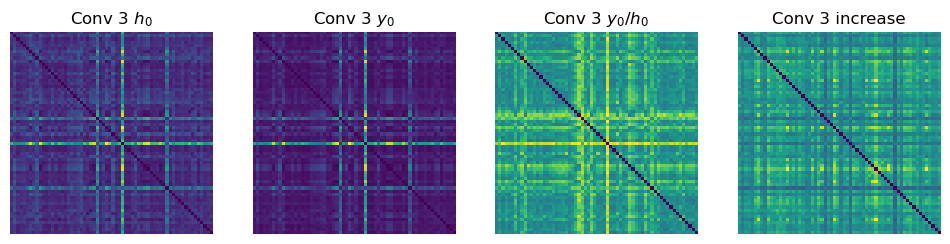

In [12]:
k_h_0 = kernel(hs_0[2])
k_y_0 = kernel(hs_0[5])
k_h = kernel(hs[2])
# k_y = kernel(hs[5])
k_y_true = kernel(true_outputs)

fig = plt.figure(figsize=(12, 12))

plt.subplot(1, 4, 1)
prediction = k_h_0
np.fill_diagonal(prediction, 0)
plt.imshow(prediction)
plt.axis("off")
plt.title("Conv 3 $h_0$")

plt.subplot(1, 4, 2)
prediction = k_y_0
np.fill_diagonal(prediction, 0)
plt.imshow(prediction)
plt.axis("off")
plt.title("Conv 3 $y_0$")

plt.subplot(1, 4, 3)
prediction = k_y_0 / k_h_0
np.fill_diagonal(prediction, 0)
plt.imshow(prediction)
plt.axis("off")
plt.title("Conv 3 $y_0/h_0$")

plt.subplot(1, 4, 4)
final = k_h / k_h_0
np.fill_diagonal(final, 0)
plt.imshow(final)
plt.axis("off")
plt.title("Conv 3 increase")
plt.show()

/tmp/ipykernel_9092/1321337735.py:3: RuntimeWarning: invalid value encountered in divide
  x = (k_y_0 / k_h_0).ravel()
/tmp/ipykernel_9092/1321337735.py:4: RuntimeWarning: invalid value encountered in divide
  y = (k_h / k_h_0).ravel()


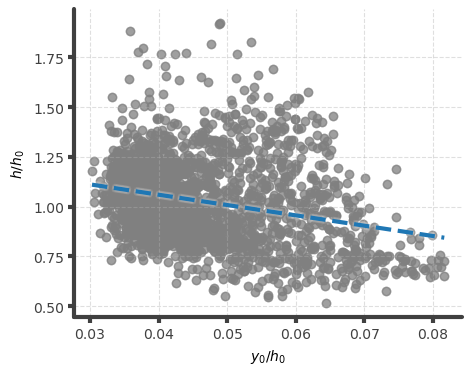

In [13]:
fig = plt.figure(figsize=(5, 4))

x = (k_y_0 / k_h_0).ravel()
y = (k_h / k_h_0).ravel()
x, y = x[~np.isnan(x)], y[~np.isnan(y)]

regr = scipy.stats.linregress(x, y)
a, b = regr.slope, regr.intercept
X = np.linspace(np.min(x), np.max(x), 300)

plt.scatter(x, y)
plt.xlabel("$y_0/h_0$")
plt.ylabel("$h / h_0$")
plt.plot(X, a * X + b, linestyle="--")
# plt.show()
pub_show(colors="contrast")